<a href="https://colab.research.google.com/github/shoraj1551/FisherfaceMethod/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importing the data

In [ ]:
!wget https://github.com/shoraj1551/FisherfaceMethod/raw/master/Face%20Data.zip
!unzip Face\ Data.zip

--2020-09-28 08:30:55--  https://github.com/shoraj1551/FisherfaceMethod/raw/master/Face%20Data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shoraj1551/FisherfaceMethod/master/Face%20Data.zip [following]
--2020-09-28 08:30:56--  https://raw.githubusercontent.com/shoraj1551/FisherfaceMethod/master/Face%20Data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8308429 (7.9M) [application/zip]
Saving to: ‘Face Data.zip’

Face Data.zip       100%[===================>]   7.92M  17.4MB/s    in 0.5s    

2020-09-28 08:30:59 (17.4 MB/s) - ‘Face Data.zip’ saved [8308429/8308429]

Archive:  Face Data.zi

In [ ]:
data_train_A="/content/Face Data/YaleA/facedatatrainresizedA/"
data_test_A="/content/Face Data/YaleA/facedataresizedtest/"
data_train_B="/content/Face Data/YaleB/CroppedYaleBResizedtrain/"
data_test_B="/content/Face Data/YaleB/CroppedYaleBResizedTest/"

Importing libraries

In [ ]:
import cv2
import os
import pickle
import skimage.io as sk
import matplotlib.pyplot as plt
import numpy as np
import math
from numpy.linalg import inv
import time

Defining importent functions


In [ ]:
def average_face(X, img_shape):
    images = np.asarray(X) 
    image_sum = np.asarray([np.sum(i) for i in images.T])
    avg_face = image_sum.reshape(img_shape)/len(X)
    return avg_face.flatten()


In [ ]:
def first_k_eigenfaces(A,k):
    '''Returns the first k eigenfaces in an array'''
    u,e,vh=np.linalg.svd(A,full_matrices=False)
    u=u.T
    return u[:k]

def first_k_eigenvectors(A,k):
    ''' Returns the first k fisherface in an array'''
    e , u = np.linalg.eig(A)
    pairs = [(np.abs(e[i]),u[:,i]) for i in range(len(e))]
    pairs = sorted(pairs,key = lambda x:x[0], reverse = True)
    v = u[0: ,0:k].real
    v = v.T
    return v[:k]
    
def NNC(x):
    proj_img = projection_image(W_opt,x,img_shape)
    distance = []
    for j in range(len(projections)):
        distance.append(np.linalg.norm(x.flatten()-projections[j].flatten()))
    index = distance.index(min(distance))
    pred = y_true[index]
    return pred



In [ ]:
def phi_image(x,y):
    return x.flatten()-y

def omega_image(x,y): #returns omega=[w1,w2,..] of the image I.e the coordinates of the image in face space
    return x.T@y.flatten()
   
def projection_image(x,y,z):
    '''returns the projection the image in face space'''
    return (omega_image(x,y)@x.T).T.reshape(z) 

def accuracy_score(A,B):
    correct = 0
    if len(A)== len(B):
        for i in range (len(A)):
            if A[i]==B[i]:
                correct = correct+1
        return correct/len(A)
    else:
        print("Comparing wrong list")

Yale A face Dataset: It contains 15 classes having 11 images each. 
Train Set: In our training set we have 135 images, total 15 classes having 9 images each.
Test Set: In our training set we have 30 images, total 15 classes having 2 images each.

For both training and testing, each image is of uniform size 100*100. 

Read the data

In [ ]:
im_list = []
data = []
clwise = {}
y_true = []
for i in os.listdir(data_train_A):
    image = sk.imread(data_train_A+i,0).flatten()/255
    im_list.append(image)
    y_true.append(int(i[7:9]))
    clwise.setdefault(i[7:9],[]).append(image)
img_shape = cv2.imread(data_train_A+i,0).shape

Average face of the dataset

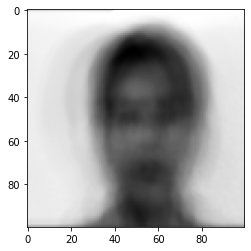

In [ ]:
avg_face = average_face(im_list,img_shape)
plt.imshow(avg_face.reshape(img_shape),cmap="gray")
plt.show()

Average face of each class of Data

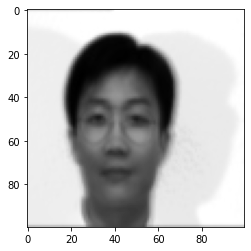

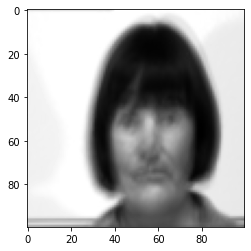

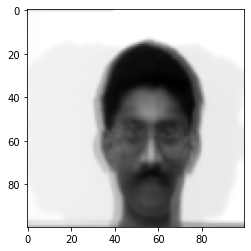

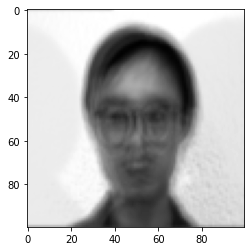

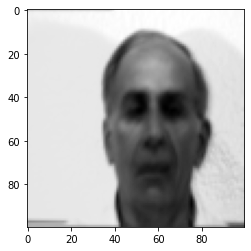

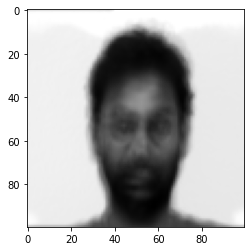

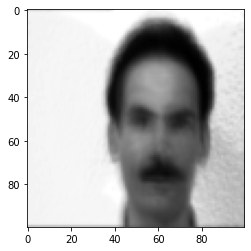

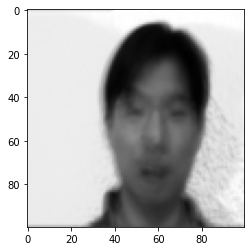

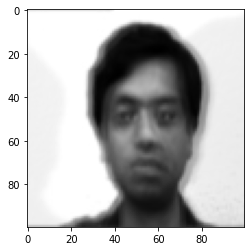

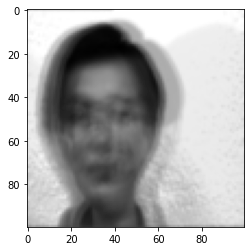

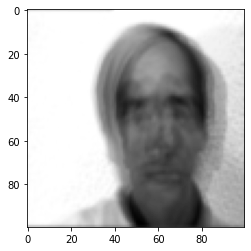

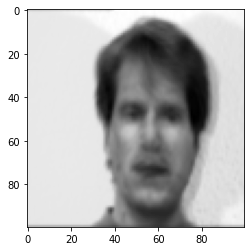

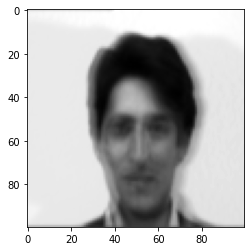

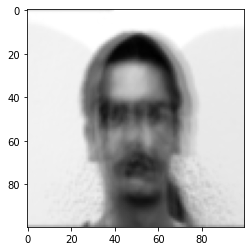

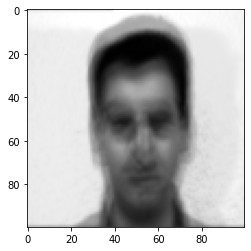

In [ ]:
cls_avg = {}
for i in clwise.keys():
  avg_face = average_face(clwise[i],img_shape)
  cls_avg[i] = avg_face
  plt.imshow(avg_face.reshape(img_shape),cmap="gray")
  plt.show()

Dimensionality reduction: find Principal component of Data set

In [ ]:
A=np.asarray([img-avg_face for img in im_list])
k = len(im_list) - len(clwise)
W_pca = first_k_eigenfaces(A.T,k).T
print(W_pca)
print(W_pca.shape)

[[ 1.65115447e-03 -1.83737492e-03 -4.27167030e-03 ... -9.99438564e-04
  -5.78827778e-05  2.87352712e-03]
 [ 1.47402070e-03 -1.08655169e-03 -4.13018021e-03 ... -2.92905531e-05
  -1.52055686e-03  3.42747084e-03]
 [ 9.64604340e-04 -1.40943040e-03 -3.84235025e-03 ... -1.67060644e-03
  -1.95423338e-04  4.95295966e-03]
 ...
 [-8.76660480e-03 -3.45651349e-03 -7.90120655e-03 ...  1.05867675e-02
  -9.36936276e-03 -1.89422326e-03]
 [-8.16119823e-03 -3.15048108e-03 -7.76003781e-03 ...  9.64280804e-03
  -1.03984441e-02 -1.04386577e-03]
 [-8.32203888e-03 -3.89289365e-03 -7.67779353e-03 ...  8.94079985e-03
  -1.04443471e-02 -1.27789050e-03]]
(10000, 120)


plotting the top 9 eigenfaces


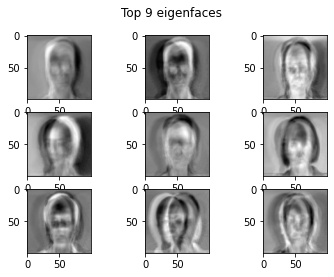

In [ ]:
print("plotting the top 9 eigenfaces")
fig,axes=plt.subplots(3,3)
for i in  range(3):
    for j in range (3):
        axes[i,j].imshow(W_pca.T[j+i*3].reshape(img_shape),cmap="gray")
plt.suptitle("Top 9 eigenfaces")
plt.show()

Find the Between class scatter matrix S_b

In [ ]:
start = time.time()
d = int(img_shape[0])*int(img_shape[1])
S_b = np.zeros((d,d),dtype = np.float32)
for i,j in cls_avg.items():
    u = phi_image(j,avg_face).reshape(d,1)
    S_b += len(clwise[i])*u@u.T
print(S_b)
print(S_b.shape)
end = time.time()
print(end-start)

[[ 0.06652313  0.06063992  0.04030587 ... -0.08733563 -0.07807766
  -0.08131915]
 [ 0.06063992  0.06750566  0.04717673 ... -0.12944423 -0.11811183
  -0.13423213]
 [ 0.04030587  0.04717673  0.04830962 ...  0.01833141  0.01715751
   0.01048828]
 ...
 [-0.08733563 -0.12944423  0.01833141 ...  2.4733      2.3977976
   2.557999  ]
 [-0.07807766 -0.11811183  0.01715751 ...  2.3977976   2.3775952
   2.5484128 ]
 [-0.08131915 -0.13423213  0.01048828 ...  2.557999    2.5484128
   2.754867  ]]
(10000, 10000)
8.064733028411865


Find the Between class scatter matrix S_w

In [ ]:
start = time.time()
S_w = np.zeros((d,d), dtype = np.float32)
for i in clwise.keys():
  for j in clwise[i]:
    v = phi_image(j,cls_avg[i]).reshape(d,1)
    S_w += v@v.T
print(S_w)
print(S_w.shape)
end = time.time()
print(end-start)

[[0.81705004 0.77307016 0.7653006  ... 0.05237474 0.07148018 0.09826648]
 [0.77307016 0.7499645  0.74221224 ... 0.09150498 0.11294459 0.138246  ]
 [0.7653006  0.74221224 0.7541101  ... 0.10921273 0.12953137 0.15178946]
 ...
 [0.05237474 0.09150498 0.10921273 ... 2.71835    2.659883   2.6160975 ]
 [0.07148018 0.11294459 0.12953137 ... 2.659883   2.6527264  2.628945  ]
 [0.09826648 0.138246   0.15178946 ... 2.6160975  2.628945   2.662952  ]]
(10000, 10000)
64.77642226219177


projection of S_b and S_w over principal component space

In [ ]:
S_bb = W_pca.T @ S_b @ W_pca
S_ww = W_pca.T @ S_w @ W_pca

Apply the fisher linear discriminant method: we find out Wfld i.e., the matrix of eigenvectors Such that in projected space, it maximizes the ratio of between class scatter and within class scatter matrix.

In [ ]:
start = time.time()
W_fld = first_k_eigenvectors(inv(S_ww)@S_bb, len(cls_avg)-1).T
print(W_fld)
print(W_fld.shape)
end = time.time()
print(end-start)

[[-0.09863158 -0.01010586 -0.06531935 ... -0.00265386 -0.0025064
  -0.00479386]
 [-0.08324958 -0.00363758 -0.0463858  ... -0.00939798 -0.0053614
   0.00261472]
 [-0.02053857  0.0109667   0.07619327 ... -0.00939921 -0.00933754
   0.00281739]
 ...
 [ 0.00979021 -0.07078909  0.0524032  ... -0.01153789  0.00794724
   0.0523098 ]
 [-0.06895566  0.09520258  0.05087412 ... -0.01200231  0.06742229
  -0.01412882]
 [ 0.05297944 -0.0192042   0.01973836 ...  0.02839268  0.00546041
   0.04923384]]
(120, 14)
0.13420939445495605


Fisherfaces and projection of images in fisherface space

In [ ]:
W_opt = (W_pca @ W_fld)
print(W_opt)

[[-0.00178947 -0.00213164 -0.00077706 ...  0.00048673 -0.00662562
   0.00967033]
 [-0.00414084  0.00017035  0.00041833 ...  0.00109287 -0.00627892
   0.01075877]
 [-0.00520174 -0.00066016  0.00275358 ... -0.0009971  -0.00878924
   0.01459525]
 ...
 [ 0.01735805 -0.00884851  0.00203586 ... -0.00576185 -0.00665076
   0.00376157]
 [ 0.01572222 -0.01119026 -0.00170371 ... -0.00824753 -0.01106467
   0.01114978]
 [ 0.0089356  -0.00931678  0.00017978 ... -0.00792397 -0.01014418
   0.01824659]]


In [ ]:
projections = []
for i in im_list:
  projections.append(projection_image(W_opt,i,img_shape))

plotting a few images and their projections


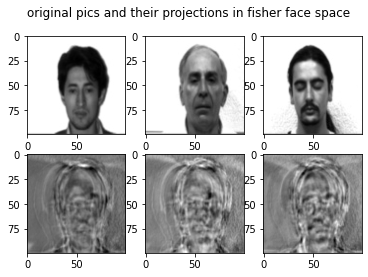

In [ ]:
print("plotting a few images and their projections")
fig,axes=plt.subplots(2,3)
for i in range(3):
    img=im_list[10*i+24].reshape(img_shape)
    axes[0,i].imshow(img,cmap="gray")
    proj_img = projections[10*i+24]
    axes[1,i].imshow(proj_img,cmap="gray")

plt.suptitle("original pics and their projections in fisher face space")
plt.show()

calculating the distance of each image with its projection image

In [ ]:
projection_distance=[]
for i in range(len(im_list)):
  projection_distance.append(np.linalg.norm(im_list[i].flatten()-projections[i].flatten()))
train_dist = np.asarray(projection_distance)
print(train_dist)

[80.87293636 77.55282253 83.77508935 81.72919621 82.99961365 81.18197685
 83.59224669 78.23618561 81.58242719 78.46333156 78.99509648 60.94515047
 76.21658985 83.23802953 78.27917177 82.74731726 73.24188454 82.01102629
 78.97676578 85.84564275 82.88887406 81.20132277 76.87157096 80.22096888
 80.1649341  78.17713029 80.33512457 78.93404611 71.44833979 80.12310094
 83.4425435  81.61343403 73.62239666 69.94167651 83.09595629 82.87560897
 83.60812686 82.73276216 83.21047854 78.2433887  82.73621434 82.4568359
 79.23653909 69.88685104 82.68430825 81.61567802 82.78773335 74.31377915
 78.2433887  77.72207226 83.089301   74.66183077 82.87560897 67.45704382
 78.27846963 81.85640395 73.65612902 82.07096751 74.1927958  76.85177977
 80.00313215 76.27410563 83.49014796 61.31314188 78.34788788 81.75747351
 77.12218688 83.33203577 68.35221079 74.25376823 81.5688684  68.87718284
 76.61554846 73.44880565 78.51687825 80.69557929 76.64754873 78.17713029
 83.62779456 67.49707984 72.39997445 78.74825038 80.

Test: 

In [ ]:
test_faces=os.listdir(data_test_A)
test_images=[sk.imread(data_test_A+i,0).flatten()/255 for i in test_faces]
y_test = [int(i[7:9]) for i in test_faces]
y_pred = []
for j in range(len(test_images)):
    pred = NNC(test_images[j])
    y_pred.append(pred)
    print(y_test[j]," --> ", pred)

15  -->  15
14  -->  14
1  -->  1
5  -->  5
10  -->  10
12  -->  12
3  -->  15
7  -->  7
13  -->  13
11  -->  11
4  -->  4
15  -->  15
7  -->  7
5  -->  5
11  -->  11
8  -->  8
14  -->  14
8  -->  15
1  -->  1
13  -->  13
9  -->  9
4  -->  4
9  -->  9
12  -->  12
2  -->  2
3  -->  15
6  -->  6
10  -->  10
2  -->  2
6  -->  6


Accuracy Score

In [ ]:
accuracy_score(y_test, y_pred)

0.9

In [ ]:
print(y_test)
print(y_pred)

[15, 14, 1, 5, 10, 12, 3, 7, 13, 11, 4, 15, 7, 5, 11, 8, 14, 8, 1, 13, 9, 4, 9, 12, 2, 3, 6, 10, 2, 6]
[15, 14, 1, 5, 10, 12, 15, 7, 13, 11, 4, 15, 7, 5, 11, 8, 14, 15, 1, 13, 9, 4, 9, 12, 2, 15, 6, 10, 2, 6]


Apply the same algorithm For Yale B face data set. In this data set there are total of 2347 images distributed among 38 different classes out of which we have 1891 images for training and 456 images for testing. In each classes images are varying under different light conditions and facial expressions.

YaleB Dataset

In [ ]:
start=time.time()
im_list= []
clwise = {}
y_true = []
for i in os.listdir(data_train_B):
  for j in os.listdir(data_train_B+i):
    image = sk.imread(data_train_B+i+"/"+j,1).flatten()/255
    im_list.append(image)
    y_true.append(i[5:7])
    clwise.setdefault(i[5:7],[]).append(image)
img_shape=cv2.imread(data_train_B+i+"/"+j,0).shape
time_check=time.time()
print(time_check-start)

1.5110712051391602


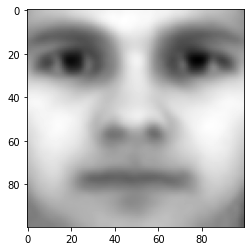

In [ ]:
avg_face = average_face(im_list,img_shape)
plt.imshow(avg_face.reshape(img_shape),cmap="gray")
plt.show()

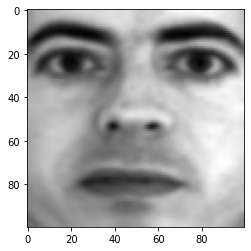

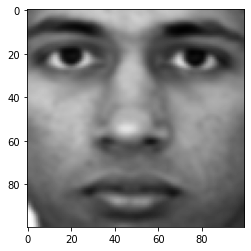

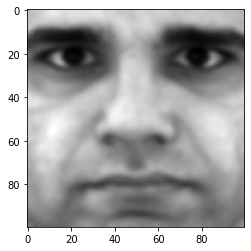

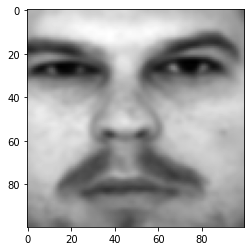

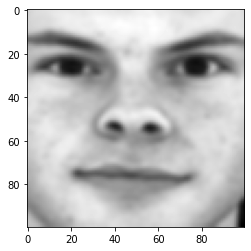

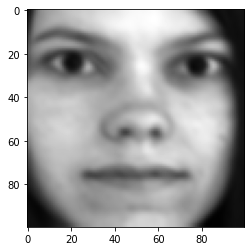

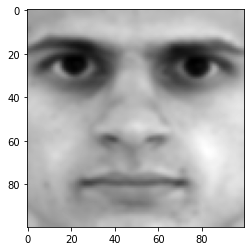

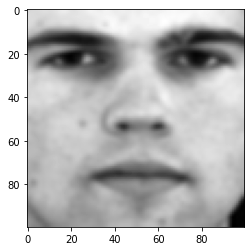

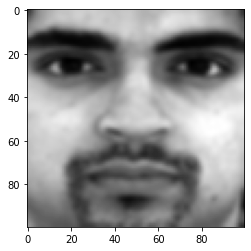

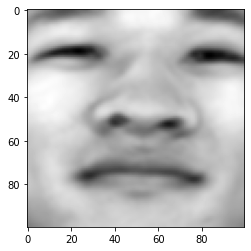

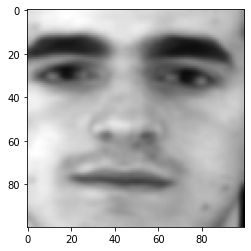

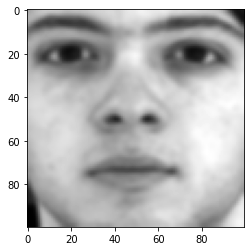

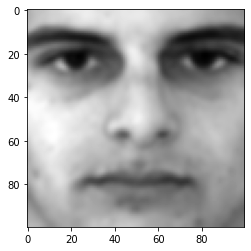

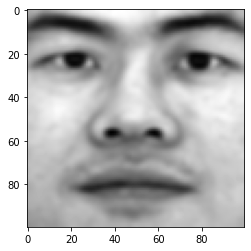

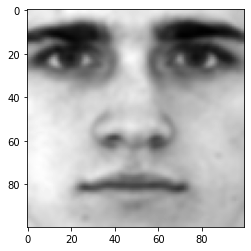

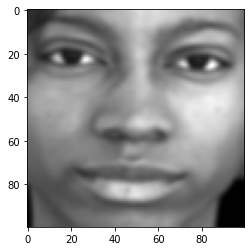

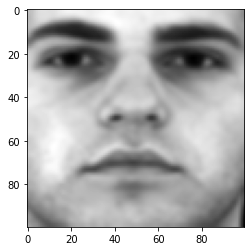

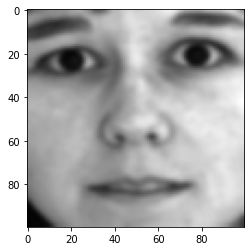

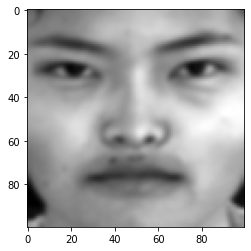

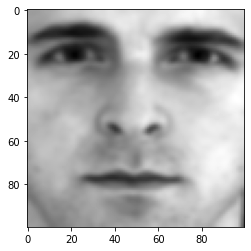

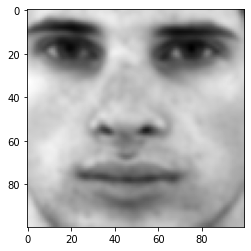

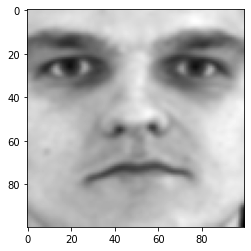

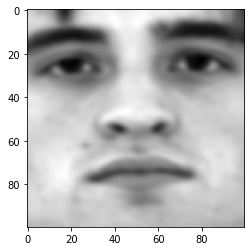

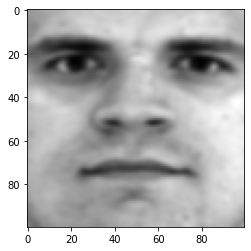

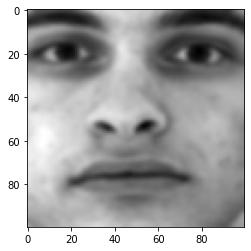

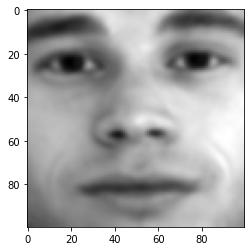

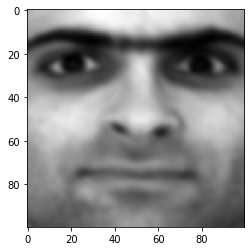

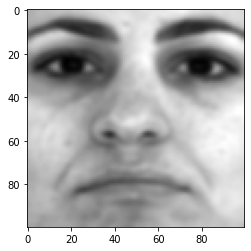

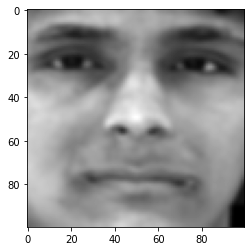

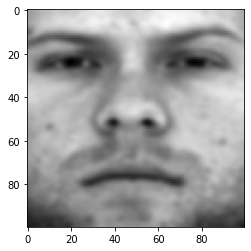

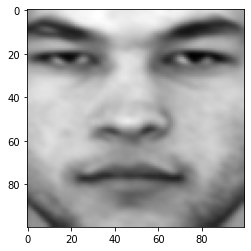

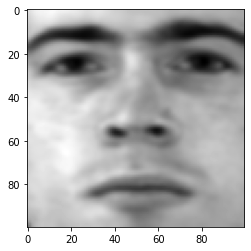

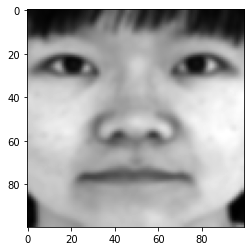

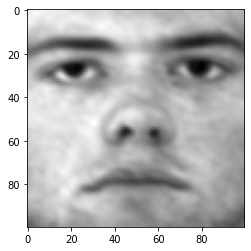

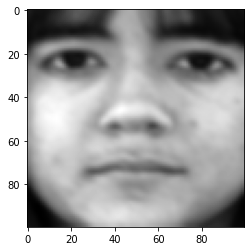

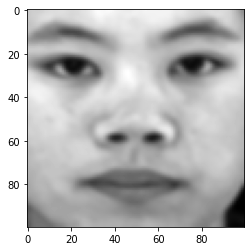

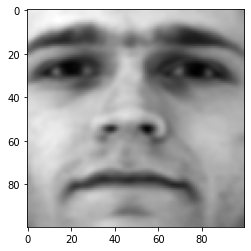

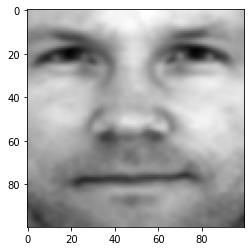

In [ ]:
cls_avg = {}
for i in clwise.keys():
  avg_face = average_face(clwise[i],img_shape)
  cls_avg[i] = avg_face
  plt.imshow(avg_face.reshape(img_shape),cmap="gray")
  plt.show()

In [ ]:
A=np.asarray([img-avg_face for img in im_list])
k = len(im_list) - len(clwise)
W_pca = first_k_eigenfaces(A.T,k).T
print(W_pca)
print(W_pca.shape)

[[-1.55386932e-04 -1.47640489e-02 -8.86511024e-03 ...  2.67366992e-03
  -1.04584522e-02  8.08244953e-03]
 [ 7.13801022e-05 -1.48479542e-02 -9.27207659e-03 ... -4.97655656e-04
  -5.26279246e-03  6.61748813e-03]
 [ 4.66523043e-04 -1.50289093e-02 -1.00440137e-02 ...  5.35122995e-03
   1.86820733e-02 -5.57817295e-03]
 ...
 [ 2.54895750e-03  9.49588984e-03  1.32433691e-02 ...  3.08728653e-03
  -1.18903194e-04 -6.68825655e-03]
 [ 2.67439603e-03  8.68026525e-03  1.06236042e-02 ... -8.51010084e-03
   1.04268002e-02 -1.61718377e-02]
 [ 2.76477980e-03  8.16638785e-03  9.15075032e-03 ... -4.96689242e-03
   8.84815097e-03  6.43435986e-03]]
(10000, 1853)


plotting the top 9 eigenfaces


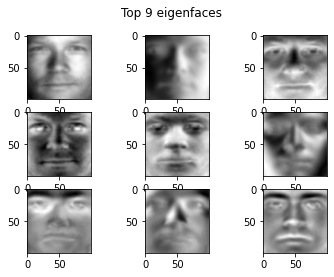

In [ ]:
print("plotting the top 9 eigenfaces")
fig,axes=plt.subplots(3,3)
for i in  range(3):
    for j in range (3):
        axes[i,j].imshow(W_pca.T[j+i*3].reshape(img_shape),cmap="gray")
plt.suptitle("Top 9 eigenfaces")
plt.show()

In [ ]:
start = time.time()
d = int(img_shape[0])*int(img_shape[1])
S_b = np.zeros((d,d),dtype = np.float32)
for i,j in cls_avg.items():
    u = phi_image(j,avg_face).reshape(d,1)
    S_b += len(clwise[i])*u@u.T
print(S_b)
print(S_b.shape)
end = time.time()
print(end-start)

[[5.58673288e-04 5.61493798e-04 5.63430367e-04 ... 4.54620349e-05
  8.75728147e-05 1.11463858e-04]
 [5.61493798e-04 5.65429684e-04 5.69208118e-04 ... 4.10344473e-05
  8.41657311e-05 1.08890075e-04]
 [5.63430367e-04 5.69208118e-04 5.76325401e-04 ... 3.27965427e-05
  7.72282729e-05 1.03000981e-04]
 ...
 [4.54620349e-05 4.10344473e-05 3.27965427e-05 ... 3.31110845e-04
  3.10568634e-04 2.93551537e-04]
 [8.75728147e-05 8.41657311e-05 7.72282729e-05 ... 3.10568634e-04
  3.21983272e-04 3.24694905e-04]
 [1.11463858e-04 1.08890075e-04 1.03000981e-04 ... 2.93551537e-04
  3.24694905e-04 3.40236118e-04]]
(10000, 10000)
20.522886991500854


In [ ]:
start = time.time()
S_w = np.zeros((d,d), dtype = np.float32)
for i in clwise.keys():
  for j in clwise[i]:
    v = phi_image(j,cls_avg[i]).reshape(d,1)
    S_w += v@v.T
print(S_w)
print(S_w.shape)
end = time.time()
print(end-start)

[[ 0.0019201   0.00191212  0.0018969  ... -0.00093838 -0.00087039
  -0.00082703]
 [ 0.00191212  0.00190828  0.00189943 ... -0.0009376  -0.00086948
  -0.00082624]
 [ 0.0018969   0.00189943  0.0019026  ... -0.00093715 -0.0008683
  -0.00082488]
 ...
 [-0.00093838 -0.0009376  -0.00093715 ...  0.00119055  0.00113247
   0.00108892]
 [-0.00087039 -0.00086948 -0.0008683  ...  0.00113247  0.00111379
   0.00109498]
 [-0.00082703 -0.00082624 -0.00082488 ...  0.00108892  0.00109498
   0.00109385]]
(10000, 10000)
899.4260561466217


In [ ]:
S_bb = W_pca.T @ S_b @ W_pca
S_ww = W_pca.T @ S_w @ W_pca

In [ ]:
start = time.time()
W_fld = first_k_eigenvectors(inv(S_ww)@S_bb, len(cls_avg)-1).T
print(W_fld)
print(W_fld.shape)
end = time.time()
print(end-start)

[[ 3.14995346e-04 -1.02135985e-03  4.59715655e-04 ...  8.74538208e-05
   7.61168798e-05 -1.13166409e-05]
 [-9.10634159e-05  1.21009466e-04 -2.09170757e-05 ... -1.78582678e-05
   5.10782811e-05  1.54958215e-05]
 [ 1.35736059e-04  3.12005715e-03 -1.75666181e-03 ... -2.19853871e-04
   2.54769527e-04 -1.53005894e-04]
 ...
 [-2.04255472e-02  5.26882621e-02  3.81017828e-02 ...  2.34138118e-02
  -8.11487425e-02  5.68623911e-02]
 [ 5.21171456e-03  2.78010354e-02  7.94745053e-03 ...  1.11971657e-02
  -5.48554862e-03 -7.29474767e-03]
 [-3.78676610e-02  1.22281416e-02  3.58788357e-02 ...  8.33703859e-02
  -4.04674923e-02 -1.06895555e-01]]
(1853, 37)
8.64586091041565


In [ ]:
W_opt = (W_fld.T @ W_pca.T).T
print(W_opt,W_opt.shape)

[[ 1.11878176e-02 -3.56893013e-03  8.78674387e-03 ...  1.59244285e-02
  -2.04359194e-02 -1.90517530e-02]
 [ 5.53586964e-03  1.37794252e-02 -1.59443377e-03 ...  3.91615902e-03
  -4.49600200e-03 -1.16961178e-02]
 [-5.01283120e-03  4.85024047e-03 -1.32129752e-02 ...  2.78067632e-05
  -1.13013768e-02 -1.43221563e-03]
 ...
 [ 3.10282749e-03  1.90291330e-02  9.09400909e-03 ... -5.00139023e-03
   1.31298235e-02  1.86987279e-03]
 [ 6.34907977e-03 -6.06505356e-03 -7.05106298e-04 ... -1.94412304e-02
   2.39828399e-04  1.16245386e-02]
 [-1.04428774e-02 -1.65920966e-02 -6.49832005e-03 ... -2.02452241e-02
  -1.22642570e-03  5.83037796e-03]] (10000, 37)


plotting the top 9 fisherfaces


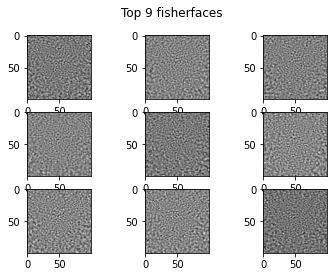

In [ ]:
print("plotting the top 9 fisherfaces")
fig,axes=plt.subplots(3,3)
for i in  range(3):
    for j in range (3):
        axes[i,j].imshow(W_opt.T[j+i*3].reshape(img_shape),cmap="gray")
plt.suptitle("Top 9 fisherfaces")
plt.show()

In [ ]:
projections = []
for i in im_list:
  projections.append(projection_image(W_opt,i,img_shape))

plotting a few images and their projections


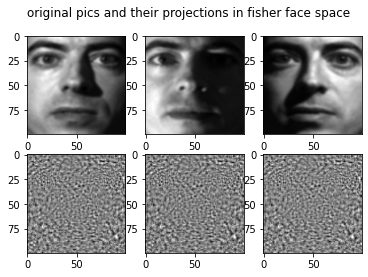

In [ ]:
print("plotting a few images and their projections")
fig,axes=plt.subplots(2,3)
for i in range(3):
    img=im_list[10*i+24].reshape(img_shape)
    axes[0,i].imshow(img,cmap="gray")
    proj_img = projections[10*i+24]
    axes[1,i].imshow(proj_img,cmap="gray")

plt.suptitle("original pics and their projections in fisher face space")
plt.show()

In [ ]:
projection_distance=[]
for i in range(len(im_list)):
  projection_distance.append(np.linalg.norm(im_list[i].flatten()-projections[i].flatten()))
train_dist = np.asarray(projection_distance)
print(train_dist)

[0.17150246 0.11962244 0.19642173 ... 0.20353126 0.17039471 0.11818709]


Here we predict the class of test image using Nearest neighbour classifier. In this case for each test image we find distance of its projection with every image in training data set and predict the class according to class of image having minimum distance with test image.

In [ ]:
test_images = []
y_test = []
for i in os.listdir(data_test_B):
  for j in os.listdir(data_test_B+i):
    image = sk.imread(data_test_B+i+"/"+j,1).flatten()/255
    test_images.append(image)
    y_test.append(i[5:7])
y_pred = []
for j in range(len(test_images)):
    pred = NNC(test_images[j])
    y_pred.append(pred)
    print(y_test[j]," --> ", pred)

06  -->  06
06  -->  06
06  -->  06
06  -->  06
06  -->  06
06  -->  06
06  -->  06
06  -->  06
06  -->  06
06  -->  06
06  -->  06
06  -->  06
12  -->  12
12  -->  12
12  -->  12
12  -->  12
12  -->  12
12  -->  12
12  -->  12
12  -->  12
12  -->  12
12  -->  12
12  -->  12
12  -->  12
08  -->  08
08  -->  08
08  -->  08
08  -->  08
08  -->  08
08  -->  08
08  -->  08
08  -->  08
08  -->  08
08  -->  08
08  -->  08
08  -->  08
21  -->  21
21  -->  21
21  -->  21
21  -->  21
21  -->  21
21  -->  21
21  -->  21
21  -->  21
21  -->  21
21  -->  21
21  -->  21
21  -->  21
16  -->  16
16  -->  16
16  -->  16
16  -->  16
16  -->  16
16  -->  16
16  -->  16
16  -->  16
16  -->  16
16  -->  16
16  -->  16
16  -->  16
28  -->  28
28  -->  28
28  -->  28
28  -->  28
28  -->  28
28  -->  28
28  -->  28
28  -->  28
28  -->  28
28  -->  28
28  -->  28
28  -->  28
31  -->  31
31  -->  31
31  -->  31
31  -->  31
31  -->  31
31  -->  31
31  -->  31
31  -->  31
31  -->  03
31  -->  31
31  -->  31
31  

In [ ]:
accuracy_score(y_test, y_pred)

0.9868421052631579